## Setup code

In [2]:
import os
import sys
from pathlib import Path

import pkg_resources

# Install dependencies
installed_packages = [pkg.key for pkg in pkg_resources.working_set]
if "transformer-lens" not in installed_packages:
    %pip install transformer_lens==2.14.1 sae-lens sae-vis einops eindex-callum jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

# root = "./content"

# os.chdir(root)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_80004/1943651544.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [4]:
import functools
import sys
from pathlib import Path
from typing import Callable

import circuitsvis as cv
import einops
import random
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from eindex import eindex
import plotly.express as px
from rich import print as rprint
from rich.table import Table
from IPython.display import HTML, IFrame, clear_output, display
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.utils import get_act_name, test_prompt, to_numpy
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_vis import SaeVisConfig, SaeVisData, SaeVisLayoutConfig
from tabulate import tabulate
from transformer_lens.hook_points import HookPoint

device = t.device("cpu")
if t.mps.is_available():
    device = t.device("mps")
if t.cuda.is_available():
    device = t.device("cuda")

t.set_grad_enabled(False)

# 1️⃣ Sparse Autoencoders: Background

This homework is an upper-level introduction to the Sparse Autoencoders initially introduced by [Anthropic](https://github.com/TransformerLensOrg/TransformerLens?ysclid=m7al57nk6207670258), and is currently one of the most interesting areas of research in mechanistic interpretability.

We're highly encouraging you to read [Superposition](https://transformer-circuits.pub/2022/toy_model/index.html) paper to get a notion of the concept. Specifically, "Background & Motivation" and "Demonstrating Superposition" parts. You can also read the [Neel Nanda glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=3br1psLRIjQCOv2T4RN3V6F2) for a quick introduction.

After that - read Anthropic's dictionary learning paper (linked above): the introduction and first section (problem setup) up to and including the "Sparse Autoencoder Setup" section.

A quick summary is given below.

#### Features as a decomposition

There is significant empirical evidence suggesting that neural networks have interpretable linear directions in activation space.

If linear directions are interpretable, it's natural to think there's some "basic set" of meaningful directions which more complex directions can be created from. We call these directions features, and they're what we'd like to decompose models into. Sometimes, by happy circumstances, individual neurons appear to be these basic interpretable units. But quite often, this isn't the case.

#### Superposition hypothesis

To see how this decomposition relates to superposition, recall the **superposition hypothesis**, which postulates that neural networks “want to represent more features than they have neurons”. We think this happens via a kind of “noisy simulation”, where small neural networks exploit feature sparsity and properties of high-dimensional spaces to approximately simulate much larger much sparser neural networks.

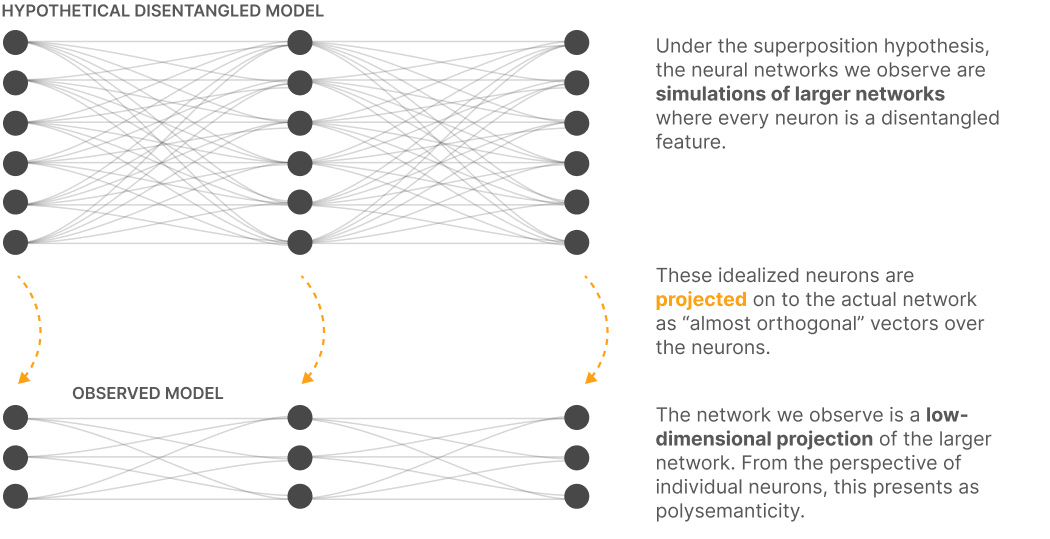

#### What is an autoencoder, and what is it trained to do?

Autoencoders are a type of neural network which learns efficient encodings / representations of unlabelled data. It is trained to compress the input in some way to a **latent representation**, then map it back into the original input space. It is trained by minimizing the reconstruction loss between the input and the reconstructed input.

The "encoding" part usually refers to the latent space being lower-dimensional than the input. However, that's not always the case, as we'll see with sparse autoencoders.

<img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/sae-diagram-2.png" width="900">

#### Why is the hidden dimension of our autoencoder larger than the number of activations, when we train an SAE on an MLP layer?

As mentioned in the previous dropdown, usually the latent vector is a compressed representation of the input because it's lower-dimensional. However, it can still be a compressed representation even if it's higher dimensional, if we enforce a sparsity constraint on the latent vector (which in some sense reduces its effective dimensionality).

As for why we do this specifically for our autoencoder use case, it's because we're trying to recover features from **superposition**, in cases where there are **more features than neurons**. We're hoping our autoencoder learns an **overcomplete feature basis**.

#### Defining Sparse Autoencoder

The sparse autoencoder is an autoencoder that takes in the hidden state activations $h_l$ of some LLM at layer $l$, map them to a larger (overcomplete) hidden state $z$, then reconstruct the original hidden state $h_l$ from $z$.

$$
\begin{aligned}
z &= \operatorname{ReLU}(W_{enc}(h_l - b_{dec}) + b_{enc}) \\
h'_l &= W_{dec}z + b_{dec}
\end{aligned}
$$

Equivalently, this can be written as a combination of more general features which can be any direction. So you can write it as follows:

$h_l ≈ b_{dec} + \sum_i f_i(h_l)d_i$,

where $f_i(h_l)$ is the activation of feature $i$, $d_i = (W_{dec})_{:, i}$ is a vector in activation space we call the *direction* of feature $i$, and $b$ is a bias. The feature activations are computed as:

$f_{i}(x) = \operatorname{ReLU}(W_{enc}(x - b_{dec}) + b_{enc})$

#### Loss function

The sparse autoencoder parameters are trained to reconstruct the original hidden state activations and ensure the sparsity of such reconstructions. This is achieved by optimizing w.r.t. the loss function:

$L = \mathbb{E}_x [||x - x'||^2_2 + \lambda \sum_i f_{i}(x)]$,

where the first term is the reconstruction loss and the second one is the L1 penalty on feature activations which ensures sparsity.

#### Why does the L1 penalty encourage sparsity?

Unlike $L_2$ penalties, the $L_1$ penalty actually pushes values towards zero. This is a well-known result in statistics, best illustrated below:

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/main/misc/l1-viz.png" width="450">

See [this Google ML page](https://developers.google.com/machine-learning/crash-course/regularization-for-sparsity/l1-regularization) for more of an explanation (it also has a nice out-of-context animation!).

## 2️⃣ SAELens

> - SAELens is a library for training and analysing SAEs. It can be thought of as the equivalent of `TransformerLens` we have considered on the seminar for SAEs (although it allso integrates closely with `TransformerLens`)
> - SAELens contains many different model releases, each release containing multiple SAEs (e.g. trained on different model layers / hook points, or with different architectures)
> - The `cfg` attribute of an `SAE` instance contains this information, and anything else that's relevant when performing forward passes

Next, we'll load the SAE which we'll be working with: the **layer 7 resid pre model** from the **GPT2 Small SAEs** (as well as a copy of GPT2 Small to attach it to). The SAE uses the `HookedSAETransformer` class, which is adapted from the TransformerLens `HookedTransformer` class.

Note, the `SAE.from_pretrained` function has return type `tuple[SAE, dict, Tensor | None]`, with the return elements being the SAE, config dict, and a tensor of feature sparsities. The config dict contains useful metadata on e.g. how the SAE was trained (among other things).

In [5]:
t.set_grad_enabled(False)

gpt2: HookedSAETransformer = HookedSAETransformer.from_pretrained("gpt2-small", device=device)

gpt2_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    device=str(device),
)

Loaded pretrained model gpt2-small into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/aigoncharov/dev/sktech/sktech-trustworty-ai/.venv/lib/python3.12/site-packages/sae_lens/sae.py:146: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


The `sae` object is an instance of the `SAE` (Sparse Autoencoder) class. There are many different SAE architectures which may have different weights or activation functions. In order to simplify working with SAEs, `SAELens` handles most of this complexity for you. You can run the cell below to see each of the SAE config parameters for the one we'll be using.

In [6]:
print(tabulate(gpt2_sae.cfg.__dict__.items(), headers=["name", "value"], tablefmt="simple_outline"))

┌──────────────────────────────┬──────────────────────────────────┐
│ name                         │ value                            │
├──────────────────────────────┼──────────────────────────────────┤
│ architecture                 │ standard                         │
│ d_in                         │ 768                              │
│ d_sae                        │ 24576                            │
│ activation_fn_str            │ relu                             │
│ apply_b_dec_to_input         │ True                             │
│ finetuning_scaling_factor    │ False                            │
│ context_size                 │ 128                              │
│ model_name                   │ gpt2-small                       │
│ hook_name                    │ blocks.7.hook_resid_pre          │
│ hook_layer                   │ 7                                │
│ hook_head_index              │                                  │
│ prepend_bos                  │ True           

Let's have a look at our SAEs, and see what they're actually telling us.

Before we dive too deep however, let's recap something - what actually is an SAE latent?

An SAE latent is a particular *direction* in the base model's activation space, learned by the SAE. Often, these correspond to **features** in the data - in other words, meaningful semantic, syntactic or otherwise interpretable patterns or concepts that exist in the distribution of data the base model was trained on, and which were learned by the base model. These features are usually highly sparse, in other words for any given feature only a small fraction of the overall data distribution will activate that feature. It tends to be the case that sparser features are also more interpretable.

**NOTE** - technically saying "direction" is an oversimplification here, because a given latent can have multiple directions in activation space associated with them, e.g. a separate encoder and decoder direction for standard untied SAEs. When we refer to a latent direction or feature direction, we're usually but not always referring to the decoder weights ($d_i$).

There is a great hosted tool called [Neuronpedia](https://docs.neuronpedia.org/features), which hosts multiple SAEs for different models and layers.

*Neuronpedia* is a website that hosts SAE dashboards and which runs servers that can run the model and check latent activations. This makes it very convenient to check that a latent fires on the distribution of text you actually think it should fire on. We will use data from Neuronpedia for the dashboards below.

The dashboard taken from *Neuronpedia* for GPT-2 shown below provides a detailed view of a single SAE latent.

In [7]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))


latent_idx = random.randint(0, gpt2_sae.cfg.d_sae)
display_dashboard(latent_idx=latent_idx)

https://neuronpedia.org/gpt2-small/7-res-jb/10688?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Let's break down the separate components of the visualization:

1. **Latent Activation Distribution**. This shows the proportion of tokens a latent fires on, usually between 0.01% and 1%, and also shows the distribution of positive activations.  
2. **Logits Distribution**. This is the projection of the decoder weight onto the unembed and roughly gives us a sense of the tokens promoted by a latent. It's less useful in big models / middle layers.
3. **Top / Botomn Logits**. These are the 10 most positive and most negative logits in the logit weight distribution.
4. **Max Activating Examples**. These are examples of text where the latent fires and usually provide the most information for helping us work out what a latent means.
5. **Autointerp**. These are LLM-generated latent explanations, which use the rest of the data in the dashboard (in particular the max activating examples).

See this section of [Towards Monosemanticity](https://transformer-circuits.pub/2023/monosemantic-features#setup-interface) for more information.

### **Task - find interesting latents (Points: 5)**

Browse through the SAE dashboard (i.e. running the code with different random indices corresponding to different features). What interesting latents can you find? Try and find the following types of latents (or any different that seem interpretable to you):

- Latents for **token-level features**, which seem to only fire on a particular token and basically no others. Do the top logits make sense, when viewed as bigram frequencies?
- Latents for **concept-level features**, which fire not on single tokens but across multiple tokens, provided that a particular concept is present in the text (e.g. `latent_idx=4527` is an example of this). What is the concept that this latent represents? Can you see how the positive logits for this token make sense?
- **Highly sparse latents**, with activation density less than 0.05%. Does it seem more interpretable than the average latent?


### **YOUR ANSWER BELOW**

Find at least 3 latents which look interpretable to you (for example representing one of the above meanings) and give your explanation for them:

> - LATENT_IDX_1: YOUR EXPLANATION
> - LATENT_IDX_2: YOUR EXPLANATION
> - LATENT_IDX_3: YOUR EXPLANATION
> - ...

In [6]:
# play with the latens here by using `display_dashboard` with different `latent_idx`

## Running with SAEs

> In this section, you'll learn how to run forward passes with SAEs. This is a pretty simple process, which builds on much of the pre-existing infrastructure in `TransformerLens` models. Key points:

> - There's an analogous `run_with_saes` that works like `run_with_hooks`
> - There's also `run_with_cache_with_saes` that works like `run_with_cache`, but allows you to cache any SAE activations you want
> - You can use `ActivationStore` to get a large batch of activations at once

One of the key features of `HookedSAETransformer` is being able to "splice in" SAEs, replacing model activations with their SAE reconstructions. To run a forward pass with SAEs attached, you can use `model.run_with_saes(tokens, saes=[list_of_saes])`. This function has similar syntax to the standard forward pass (or to `model.run_with_hooks`), e.g. it can take arguments like `return_type` to specify whether the return type should be loss or logits. The attached SAEs will be reset immediately after the forward pass, returning the model to its original state. Under the hood, they work just like adding hooks in TransformerLens, only in this case our hooks are "replace these activations with their SAE reconstructions".

In [7]:
prompt = "Mitigating the risk of extinction from AI should be a global"
answer = " priority"

# First see how the model does without SAEs
test_prompt(prompt, answer, gpt2)

# Same thing, done in a different way
gpt2.add_sae(gpt2_sae)
test_prompt(prompt, answer, gpt2)
gpt2.reset_saes()  # Remember to always do this!

# Using `run_with_saes` method in place of standard forward pass
logits = gpt2(prompt, return_type="logits")
logits_sae = gpt2.run_with_saes(prompt, saes=[gpt2_sae], return_type="logits")
answer_token_id = gpt2.to_single_token(answer)

# Getting model's prediction
top_prob, token_id_prediction = logits[0, -1].softmax(-1).max(-1)
top_prob_sae, token_id_prediction_sae = logits_sae[0, -1].softmax(-1).max(-1)

print(f"""Standard model: top prediction = {gpt2.to_string(token_id_prediction)!r}, prob = {top_prob.item():.2%}
SAE reconstruction: top prediction = {gpt2.to_string(token_id_prediction_sae)!r}, prob = {top_prob_sae.item():.2%}
""")

Tokenized prompt: ['<|endoftext|>', 'Mit', 'igating', ' the', ' risk', ' of', ' extinction', ' from', ' AI', ' should', ' be', ' a', ' global']
Tokenized answer: [' priority']


Performance on answer token:
Rank: 0        Logit: 19.46 Prob: 52.99% Token: | priority|

Top 0th token. Logit: 19.46 Prob: 52.99% Token: | priority|
Top 1th token. Logit: 17.44 Prob:  7.02% Token: | effort|
Top 2th token. Logit: 16.94 Prob:  4.26% Token: | issue|
Top 3th token. Logit: 16.63 Prob:  3.14% Token: | challenge|
Top 4th token. Logit: 16.37 Prob:  2.42% Token: | goal|
Top 5th token. Logit: 16.06 Prob:  1.78% Token: | concern|
Top 6th token. Logit: 15.88 Prob:  1.47% Token: | focus|
Top 7th token. Logit: 15.61 Prob:  1.13% Token: | approach|
Top 8th token. Logit: 15.53 Prob:  1.04% Token: | policy|
Top 9th token. Logit: 15.42 Prob:  0.93% Token: | initiative|


Ranks of the answer tokens: [(' priority', 0)]

Tokenized prompt: ['<|endoftext|>', 'Mit', 'igating', ' the', ' risk', ' of', ' extinction', ' from', ' AI', ' should', ' be', ' a', ' global']
Tokenized answer: [' priority']


Performance on answer token:
Rank: 0        Logit: 18.19 Prob: 39.84% Token: | priority|

Top 0th token. Logit: 18.19 Prob: 39.84% Token: | priority|
Top 1th token. Logit: 16.51 Prob:  7.36% Token: | issue|
Top 2th token. Logit: 16.48 Prob:  7.20% Token: | concern|
Top 3th token. Logit: 15.94 Prob:  4.19% Token: | challenge|
Top 4th token. Logit: 15.30 Prob:  2.21% Token: | goal|
Top 5th token. Logit: 15.12 Prob:  1.85% Token: | responsibility|
Top 6th token. Logit: 15.04 Prob:  1.69% Token: | problem|
Top 7th token. Logit: 14.98 Prob:  1.60% Token: | effort|
Top 8th token. Logit: 14.73 Prob:  1.24% Token: | policy|
Top 9th token. Logit: 14.66 Prob:  1.16% Token: | imperative|


Ranks of the answer tokens: [(' priority', 0)]

Standard model: top prediction = ' priority', prob = 52.99%
SAE reconstruction: top prediction = ' priority', prob = 39.84%



Okay, so this is fine if we want to do a forward pass with the model's output replaced by SAE output, but what if we want to just get the SAE activations? Well, that's where running with cache comes in! With `HookedSAETransformer`, you can cache SAE activations (and all the other standard activations) with `logits, cache = model.run_with_cache_with_saes(tokens, saes=saes)`. Just as `run_with_saes` is a wapper around the standard forward pass, `run_with_cache_with_saes` is a wrapper around `run_with_cache`, and will also only add these saes for one forward pass before returning the model to its original state.

To access SAE activations from the cache, the corresponding hook names will generally be the concatenations of the HookedTransformer `hook_name` (e.g. `"blocks.5.attn.hook_z"`) and the SAE hook name (e.g. `"hook_sae_acts_post"`), joined by a period. We can print out all the names below:

In [8]:
_, cache = gpt2.run_with_cache_with_saes(prompt, saes=[gpt2_sae])

for name, param in cache.items():
    if "hook_sae" in name:
        print(f"{name:<43}: {tuple(param.shape)}")

blocks.7.hook_resid_pre.hook_sae_input     : (1, 13, 768)
blocks.7.hook_resid_pre.hook_sae_acts_pre  : (1, 13, 24576)
blocks.7.hook_resid_pre.hook_sae_acts_post : (1, 13, 24576)
blocks.7.hook_resid_pre.hook_sae_recons    : (1, 13, 768)
blocks.7.hook_resid_pre.hook_sae_output    : (1, 13, 768)


### Using `ActivationStore`

The `ActivationsStore` class is a convenient alternative to loading a bunch of data yourself. It streams in data from a given dataset; in the case of the `from_sae` class that dataset will be given by your SAE's config (which is also the same as the SAE's original training dataset):

The dataset is used to collect statistics you've seen above from *Neuronpedia*.

In [9]:
print(">>> Dataset used to train the gpt2_sae: {}".format(gpt2_sae.cfg.dataset_path))

>>> Dataset used to train the gpt2_sae: Skylion007/openwebtext


Let's load one used to train the SAE we are looking at now. We'll use fairly conservative parameters here so it can be used without running out of memory, but feel free to increase these parameters if you're able to (or decrease them if you still find yourself running out of memory).

In [10]:
gpt2_act_store = ActivationsStore.from_sae(
    model=gpt2,
    sae=gpt2_sae,
    streaming=True,
    store_batch_size_prompts=16,
    n_batches_in_buffer=32,
    device=str(device),
)

# Example of how you can use this:
tokens = gpt2_act_store.get_batch_tokens()
assert tokens.shape == (gpt2_act_store.store_batch_size_prompts, gpt2_act_store.context_size)

/usr/local/lib/python3.11/dist-packages/sae_lens/training/activations_store.py:301: UserWarning: Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors


# 3️⃣ Replicating SAE dashboards

> This is your main homework. You'll replicate the 4 main components of the SAE dashboard: top logits tables, logits histogram, activation density plots, top activating sequences. This will give you a better understanding of how the statistics are constructed and a better understanding for the meaning of them.

To review, basic SAE dashboards have 5 main components:

1. **Activation Distribution** - the distribution of a latent's activations
2. **Logits Distribution** - projection of decoder weights onto model's unembedding
3. **Top / Bottom Logits** - the most positive and most negative logits in the logit weight distribution
4. **Max Activating Examples** - sequences (and particular tokens) on which the latent fires strongest
5. **Autointerp** - llm-generated latent explanations. We won't do it in this homework because it requires some money...

We'll go through each of these (except autointerp) in turn. We'll be using latent `9` for this exercise; you can compare your results to the expected dashboard:

In [11]:
display_dashboard(latent_idx=9)

https://neuronpedia.org/gpt2-small/7-res-jb/9?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


### **Task - get the activation distribution (Points: 10+5)**

Let's start by implementing the activation distribution plot. The function below should iterate through some number of batches (note that you can reduce the default number if you find the code is taking too long), and creates a histogram of the activations for a given latent.

Reminder - when using `model.run_with_cache_with_saes`, you can use the arguments `stop_at_layer=sae.cfg.hook_layer+1` as well as `names_filter=hook_name`; these will help you avoid unnecessary computation and memory usage.

Try and return the **activation density** in the histogram's title too **(+5 bonus points)**. **Hint:** you can use `act_store` attributes to correctly derive the whole number of processed activations.

In [12]:
def show_activation_histogram(
    model: HookedSAETransformer,
    sae: SAE,
    act_store: ActivationsStore,
    latent_idx: int,
    total_batches: int = 200,
):
    """
    Displays the activation histogram for a particular latent, computed across `total_batches` batches from `act_store`.
    """
    sae_acts_post_hook_name = f"{sae.cfg.hook_name}.hook_sae_acts_post"
    all_positive_acts = []  # store`latent_idx` feature activations here (keep only the ones with values > 0)

    for i in tqdm(range(total_batches), desc="Computing activations for histogram"):
        tokens = act_store.get_batch_tokens()
        # YOUR CODE HERE:
        #   1. Run the model forward pass with SAE attached
        #   2. Collect SAE activations corresponding to the `latent_idx` feature
        #   3. Filter by choosing the activations > 0
        raise NotImplementedError("YOUR CODE HERE")

    frac_active = -1  # calculate activation density: +5 points

    px.histogram(
        all_positive_acts,
        nbins=50,
        title=f"ACTIVATIONS DENSITY {frac_active:.3%}",
        labels={"value": "Activation"},
        width=800,
        template="ggplot2",
        color_discrete_sequence=["darkorange"],
    ).update_layout(bargap=0.02, showlegend=False).show()


show_activation_histogram(gpt2, gpt2_sae, gpt2_act_store, latent_idx=9)

Computing activations for histogram: 100%|██████████| 200/200 [00:30<00:00,  6.61it/s]


### **Task - find max activating examples (Points: 20)**

Now you will find the max-activating examples - the prompts that show the highest level of activation from a latent. We've given you a function with a docstring to complete, although exactly how you want to present the data is entirely up to you.

We've given you the following helper functions, as well as examples showing how to use them:

- `get_k_largest_indices`, which will return the batch & seqpos indices of the k largest elements in a `(batch, seq)`-sized tensor,
- `index_with_buffer`, which will index into a `(batch, seq)`-sized tensor with the results of `get_k_largest_indices`, including the tokens within `buffer` from the selected indices in the same sequence (this helps us get context around the selected tokens),
- `display_top_seqs`, which will display sequences (with the relevant token highlighted) in a readable way.

When it comes to decoding sequences, you can use `model.to_str_tokens` to map a 1D tensor of token IDs to a list of string tokens. Note that you're likely to get some unknown tokens `"�"` in your output - this is an unfortunate byproduct of tokenization the way we're doing it, and you shouldn't worry about it too much.

In [ ]:
# helper functions


def get_k_largest_indices(x: Float[Tensor, "batch seq"], k: int, buffer: int = 0) -> Int[Tensor, "k 2"]:
    """
    The indices of the top k elements in the input tensor, i.e. output[i, :] is the (batch, seqpos) value of the i-th
    largest element in x.

    Won't choose any elements within `buffer` from the start or end of their sequence.
    """
    if buffer > 0:
        x = x[:, buffer:-buffer]
    indices = x.flatten().topk(k=k).indices
    rows = indices // x.size(1)
    cols = indices % x.size(1) + buffer
    return t.stack((rows, cols), dim=1)


x = t.arange(40, device=device).reshape((2, 20))
x[0, 10] += 50  # 2nd highest value
x[0, 11] += 100  # highest value
x[1, 1] += 150  # not inside buffer (it's less than 3 from the start of the sequence)
top_indices = get_k_largest_indices(x, k=2, buffer=3)
assert top_indices.tolist() == [[0, 11], [0, 10]]


def index_with_buffer(
    x: Float[Tensor, "batch seq"], indices: Int[Tensor, "k 2"], buffer: int | None = None
) -> Float[Tensor, "k *buffer_x2_plus1"]:
    """
    Indexes into `x` with `indices` (which should have come from the `get_k_largest_indices` function), and takes a
    +-buffer range around each indexed element. If `indices` are less than `buffer` away from the start of a sequence
    then we just take the first `2*buffer+1` elems (same for at the end of a sequence).

    If `buffer` is None, then we don't add any buffer and just return the elements at the given indices.
    """
    rows, cols = indices.unbind(dim=-1)
    if buffer is not None:
        rows = einops.repeat(rows, "k -> k buffer", buffer=buffer * 2 + 1)
        cols[cols < buffer] = buffer
        cols[cols > x.size(1) - buffer - 1] = x.size(1) - buffer - 1
        cols = einops.repeat(cols, "k -> k buffer", buffer=buffer * 2 + 1) + t.arange(
            -buffer, buffer + 1, device=cols.device
        )
    return x[rows, cols]


x_top_values_with_context = index_with_buffer(x, top_indices, buffer=3)
assert x_top_values_with_context[0].tolist() == [8, 9, 10 + 50, 11 + 100, 12, 13, 14]  # highest value in the middle
assert x_top_values_with_context[1].tolist() == [7, 8, 9, 10 + 50, 11 + 100, 12, 13]  # 2nd highest value in the middle


def display_top_seqs(data: list[tuple[float, list[str], int]]):
    """
    Given a list of (activation: float, str_toks: list[str], seq_pos: int), displays a table of these sequences, with
    the relevant token highlighted.

    We also turn newlines into "\\n", and remove unknown tokens � (usually weird quotation marks) for readability.
    """
    table = Table("Act", "Sequence", title="Max Activating Examples", show_lines=True)
    for act, str_toks, seq_pos in data:
        formatted_seq = (
            "".join([f"[b u green]{str_tok}[/]" if i == seq_pos else str_tok for i, str_tok in enumerate(str_toks)])
            .replace("�", "")
            .replace("\n", "↵")
        )
        table.add_row(f"{act:.3f}", repr(formatted_seq))
    rprint(table)


example_data = [
    (0.5, [" one", " two", " three"], 0),
    (1.5, [" one", " two", " three"], 1),
    (2.5, [" one", " two", " three"], 2),
]
display_top_seqs(example_data)

  Max Activating Examples   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Act   ┃ Sequence         ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 0.500 │ ' one two three' │
├───────┼──────────────────┤
│ 1.500 │ ' one two three' │
├───────┼──────────────────┤
│ 2.500 │ ' one two three' │
└───────┴──────────────────┘

You should fill in the following function. It should return `data` as a list of tuples of the form `(max activation, list of string tokens, sequence position)`, and if `display` is True then it should also call `display_top_seqs` on this data.

In [ ]:
def fetch_max_activating_examples(
    model: HookedSAETransformer,
    sae: SAE,
    act_store: ActivationsStore,
    latent_idx: int,
    total_batches: int = 100,
    k: int = 10,
    buffer: int = 10,
) -> list[tuple[float, list[str], int]]:
    """
    Returns the max activating examples across a number of batches from the activations store.
    """
    sae_acts_post_hook_name = f"{sae.cfg.hook_name}.hook_sae_acts_post"

    for _ in tqdm(range(total_batches), desc="Computing activations for max activating examples"):
        tokens = act_store.get_batch_tokens()
        # YOUR CODE HERE:
        #   1. run the model forward pass with SAE attached,
        #   2. get largest indices using `get_k_largest_indices`
        #   3. get the corresponding max acts and the surrounding indices using `index_with_buffer`
        raise NotImplementedError("YOUR CODE HERE")

    # sort the results by max activations: from one with the highest to one with the lowest, return top `k`
    return "YOUR CODE HERE"


# Fetch & display the results
buffer = 10
data = fetch_max_activating_examples(gpt2, gpt2_sae, gpt2_act_store, latent_idx=9, buffer=buffer, k=5)
display_top_seqs(data)

# Test one of the results, to see if it matches the expected output
first_seq_str_tokens = data[0][1]
assert first_seq_str_tokens[buffer] == " new"

Computing activations for max activating examples: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


                                             Max Activating Examples                                              
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Act    ┃ Sequence                                                                                              ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 43.451 │ '.↵↵Airline industry↵↵Under the new rules, payment surcharges will have to reflect the'               │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 41.921 │ '145m.↵↵Enforcement↵↵The new rules are being brought in earlier than the rest of'                     │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 39.845 │ ' activity," the minister had said.↵↵The new law is a precursor to banning chewing tobacco in public' │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 37.051 │ '."↵↵Niedermeyer agreed that the new car excitement "tapers off" the longer it'                       │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 37.004 │ ' each other as soon as possible."↵↵The new desert map will be included in the 1.0'                   │
└────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────┘

#### Non-overlapping sequences

For the latent above, returning sequences the way you did probably worked pretty well. But other more concept-level latents (where multiple tokens in a sentence fire strongly) are a bit more annoying. You can try this function on a latent like `16873` (which fires on specific bible passages) - the returned sequences will mostly be the same, just shifted over by a different amount.

In [ ]:
data = fetch_max_activating_examples(gpt2, gpt2_sae, gpt2_act_store, latent_idx=16873, total_batches=200)
display_top_seqs(data)

One way you can combat this is by emposing the restriction that any given top-activating token can only be in one sequence, i.e. when you pick that token you can't pick any in the range `[-buffer, buffer]` around it. We've given you a new function `get_k_largest_indices` below. Try it out with `no_overlap=True`, are the results much better?

In [ ]:
def get_k_largest_indices(
    x: Float[Tensor, "batch seq"],
    k: int,
    buffer: int = 0,
    no_overlap: bool = True,
) -> Int[Tensor, "k 2"]:
    """
    Returns the tensor of (batch, seqpos) indices for each of the top k elements in the tensor x.

    Args:
        buffer:     We won't choose any elements within `buffer` from the start or end of their seq (this helps if we
                    want more context around the chosen tokens).
        no_overlap: If True, this ensures that no 2 top-activating tokens are in the same seq and within `buffer` of
                    each other.
    """
    assert buffer * 2 < x.size(1), "Buffer is too large for the sequence length"
    assert not no_overlap or k <= x.size(0), "Not enough sequences to have a different token in each sequence"

    if buffer > 0:
        x = x[:, buffer:-buffer]

    indices = x.flatten().argsort(-1, descending=True)
    rows = indices // x.size(1)
    cols = indices % x.size(1) + buffer

    if no_overlap:
        unique_indices = t.empty((0, 2), device=x.device).long()
        while len(unique_indices) < k:
            unique_indices = t.cat((unique_indices, t.tensor([[rows[0], cols[0]]], device=x.device)))
            is_overlapping_mask = (rows == rows[0]) & ((cols - cols[0]).abs() <= buffer)
            rows = rows[~is_overlapping_mask]
            cols = cols[~is_overlapping_mask]
        return unique_indices

    return t.stack((rows, cols), dim=1)[:k]


x = t.arange(40, device=device).reshape((2, 20))
x[0, 10] += 150  # highest value
x[0, 11] += 100  # 2nd highest value, but won't be chosen because of overlap
x[1, 10] += 50  # 3rd highest, will be chosen
top_indices = get_k_largest_indices(x, k=2, buffer=3)
assert top_indices.tolist() == [[0, 10], [1, 10]]


data = fetch_max_activating_examples(gpt2, gpt2_sae, gpt2_act_store, latent_idx=16873, total_batches=200)
display_top_seqs(data)

### **Task - get top / bottom logits (Points: 10)**

Now, let's write the top & bottom logits tables. These don't require data, since they're just functions of the SAE and model's weights. Recall - you can access the unembedding of your base model using model.W_U, and you can access your SAE's decoder weights using sae.W_dec.

To get the logits w.r.t. a particular SAE feature (latent): W_dec[latent_idx] @ W_U

**Hint:** you can use `torch.topk` function to get the `k` largest (smallest) values and their indices.

In [ ]:
# test function to verify the correctness of your code :)

import io, contextlib


def test_show_top_logits(show_top_logits, gpt2: HookedSAETransformer, gpt2_sae: SAE):
    """
    We test by checking whether a couple of expected top tokens are in the output.
    """
    latent_idx = 9
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        show_top_logits(gpt2, gpt2_sae, latent_idx)
        output = buf.getvalue()
    assert "bies" in output, "Expected 'bies' to be in output (most positive value)"
    assert "Zip" in output, "Expected 'Zip' to be in output (most negative value)"
    print("All tests in `test_show_top_logits` passed!")

In [17]:
def show_top_logits(
    model: HookedSAETransformer,
    sae: SAE,
    latent_idx: int,
    k: int = 10,
) -> None:
    """
    Displays the top & bottom logits for a particular latent.
    """
    logits = # YOUR CODE HERE: Compute W_dec[latent_idx] @ W_U"

    pos_logits, pos_token_ids = # YOUR CODE HERE: compute top-k largest logits
    pos_tokens = # YOUR CODE HERE: get the top-k largest tokens (str format)
    neg_logits, neg_token_ids = # YOUR CODE HERE: compute top-k smallest logits
    neg_tokens = # YOUR CODE HERE: get the top-k smalles tokens (str format)

    print(
        tabulate(
            zip(map(repr, neg_tokens), neg_logits, map(repr, pos_tokens), pos_logits),
            headers=["Bottom tokens", "Value", "Top tokens", "Value"],
            tablefmt="simple_outline",
            stralign="right",
            numalign="left",
            floatfmt="+.3f",
        )
    )


show_top_logits(gpt2, gpt2_sae, latent_idx=9)
test_show_top_logits(show_top_logits, gpt2, gpt2_sae)

┌─────────────────┬─────────┬─────────────────┬─────────┐
│   Bottom tokens │ Value   │      Top tokens │ Value   │
├─────────────────┼─────────┼─────────────────┼─────────┤
│           'Zip' │ -0.774  │          'bies' │ +1.327  │
│       'acebook' │ -0.761  │           'bie' │ +1.297  │
│           'lua' │ -0.737  │     ' arrivals' │ +1.218  │
│        'ashtra' │ -0.728  │    ' additions' │ +1.018  │
│       'ONSORED' │ -0.708  │      ' edition' │ +0.994  │
│           'OGR' │ -0.705  │   ' millennium' │ +0.966  │
│      'umenthal' │ -0.703  │   ' generation' │ +0.962  │
│        'ecause' │ -0.697  │     ' entrants' │ +0.923  │
│          'icio' │ -0.692  │        ' hires' │ +0.919  │
│          'cius' │ -0.692  │ ' developments' │ +0.881  │
└─────────────────┴─────────┴─────────────────┴─────────┘
All tests in `test_show_top_logits` passed!
